# Warsztaty badawcze - Projekt KM2
## Katarzyna Solawa, Jakub Jung, Aleksander Malinowski


# Research problem
As a research problem, we chose Challenge 2 (9 circles), from the article:

H. Müller & A. Holzinger. **Kandinsky Patterns**. Artificial Intelligence, 300, 103546. 2021. URL: https://doi.org/10.1016/j.artint.2021.103546.

Our target is to train a NN to classify Kandinsky Figures according to ground truth (rule that define the pattern).
We don't know what is the ground truth, so next we want to explain Kandinsky Patter using natural language by explaining our trained model.

#### **Ground truth**
![alt text](https://images.deepai.org/converted-papers/1906.00657/images/Challenge-2-TRUE.png "Ground truth")

#### **False**
![alt text](https://images.deepai.org/converted-papers/1906.00657/images/Challenge-2-FALSE.png "False")

#### **COUNTERFACTUAL**
![alt text](https://images.deepai.org/converted-papers/1906.00657/images/Challenge-2-COUNTERFACTUAL.png "COUNTERFACTUAL")






# Data

Data size:
* 1000 counterfactual;
* 1000 false;
* 1000 true;

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

import torch
import torchvision
from  torchvision.datasets import ImageFolder 
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim

In [ ]:
!git clone https://github.com/human-centered-ai-lab/dat-kandinsky-patterns.git

Cloning into 'dat-kandinsky-patterns'...
remote: Enumerating objects: 22535, done.
remote: Total 22535 (delta 0), reused 0 (delta 0), pack-reused 22535
Receiving objects: 100% (22535/22535), 396.91 MiB | 18.92 MiB/s, done.
Resolving deltas: 100% (357/357), done.
Checking out files: 100% (11253/11253), done.


In [ ]:


transform = transforms.Compose([
      transforms.ToTensor(),
      transforms.Resize(224),
      transforms.Normalize((0.5,0.5,0.5), (0.5, 0.5, 0.5)),
])

In [ ]:
!mkdir bez_cf

In [ ]:
!cp -r /content/dat-kandinsky-patterns/challenge-nr-2/counterfactual/. /content/

In [ ]:
!cp -r /content/dat-kandinsky-patterns/challenge-nr-2/true ./bez_cf

In [ ]:
!cp -r /content/dat-kandinsky-patterns/challenge-nr-2/false ./bez_cf

In [ ]:
!rename 's/^/cf_/' *.png

In [ ]:
!cp -a ./*.png /content/bez_cf/false/

In [ ]:
!ls /content/bez_cf/false/ | wc -l

2000


In [ ]:
data = ImageFolder('/content/bez_cf', transform = transform)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

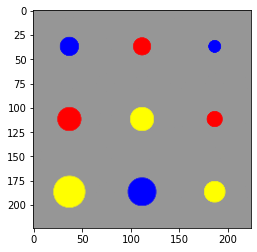

In [ ]:
imshow(torchvision.utils.make_grid(data[2000][0]))

## Split with even class size

In [ ]:
cf = torch.utils.data.Subset(data, list(range(1000)))
false = torch.utils.data.Subset(data, list(range(1000,2000)))
true = torch.utils.data.Subset(data, list(range(2000,3000)))

In [ ]:
train_cf, test_cf = torch.utils.data.random_split(cf, [800, 200])
train_false, test_false = torch.utils.data.random_split(false, [800, 200])
train_true, test_true = torch.utils.data.random_split(true, [800, 200])

In [ ]:
train = torch.utils.data.ConcatDataset([train_cf,train_false,train_true])
test = torch.utils.data.ConcatDataset([test_cf,test_false,test_true])

# Model

Using stratified labels distribution in data splitting

In [ ]:
import torch.nn as nn
import torch.nn.functional as F
class BasicBlock(torch.nn.Module):
    expansion = 1
    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = torch.nn.Conv2d(in_planes,planes,kernel_size=3,stride=stride,padding=1,bias=False)
        self.bn1 = torch.nn.BatchNorm2d(planes)
        self.conv2 = torch.nn.Conv2d(planes,planes,kernel_size=3,stride=1,padding=1,bias=False)
        self.bn2 = torch.nn.BatchNorm2d(planes)
        self.shortcut = torch.nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = torch.nn.Sequential(
              torch.nn.Conv2d(in_planes, self.expansion*planes,
                        kernel_size=1, stride=stride, bias=False),
              torch.nn.BatchNorm2d(self.expansion*planes)
            )
    def forward(self, x):
        out = torch.nn.functional.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = torch.nn.functional.relu(out)
        return out
class ResNet(torch.nn.Module):
  def __init__(self,block, num_blocks, num_classes=2):
      super(ResNet,self).__init__()
      self.in_planes = 64
      self.conv1 = torch.nn.Conv2d(3,64,kernel_size=3,stride=1,padding=1,bias=False)
      self.bn1 = torch.nn.BatchNorm2d(64)
      self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
      self.layer2 = self._make_layer(block, 128, num_blocks[1],stride=2)
      self.layer3 = self._make_layer(block, 256, num_blocks[2],stride=2)
      self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
      self.linear = torch.nn.Linear(25088*block.expansion, num_classes)

  def _make_layer(self, block, planes, num_blocks, stride):
      strides = [stride] + [1]*(num_blocks-1)
      layers = []
      for stride in strides:
          layers.append(block(self.in_planes, planes, stride))
          self.in_planes = planes * block.expansion
      return torch.nn.Sequential(*layers)
  def forward(self, x):
      out = torch.nn.functional.relu(self.bn1(self.conv1(x)))
      out = self.layer1(out)
      out = self.layer2(out)
      out = self.layer3(out)
      out = self.layer4(out)
      out = torch.nn.functional.avg_pool2d(out, 4)
      out = out.view(out.size(0), -1)
      out = self.linear(out)
      return out

def ResNet14():
    return ResNet(BasicBlock, [1, 2, 2, 1])
def ResNet10():
    return ResNet(BasicBlock, [1,1,1,1])
def ResNet26():
  return ResNet(BasicBlock, [2,4,4,2])

In [ ]:
from collections  import OrderedDict
from IPython.display import clear_output
import pandas as pd
import time
if torch.cuda.is_available():  
  DEVICE = "cuda:0" 
else:  
  DEVICE = "cpu"
from collections import namedtuple
from itertools import product
import json

# Read in the hyper-parameters and return a Run namedtuple containing all the 
# combinations of hyper-parameters
class RunBuilder():
  @staticmethod
  def get_runs(params):

    Run = namedtuple('Run', params.keys())

    runs = []
    for v in product(*params.values()):
      runs.append(Run(*v))
    
    return runs

# Helper class, help track loss, accuracy, epoch time, run time, 
# hyper-parameters etc. Also record to TensorBoard and write into csv, json
class RunManager():
  def __init__(self):

    # tracking every epoch count, loss, accuracy, time
    self.epoch_count = 0
    self.epoch_loss = 0
    self.epoch_num_correct = 0
    self.epoch_start_time = None

    # tracking every run count, run data, hyper-params used, time
    self.run_params = None
    self.run_count = 0
    self.run_data = []
    self.run_start_time = None

    # record model, loader and TensorBoard 
    self.network = None
    self.loader = None
    self.loader_test = None

  # record the count, hyper-param, model, loader of each run
  # record sample images and network graph to TensorBoard  
  def begin_run(self, run, network, loader, loader_test):

    self.run_start_time = time.time()

    self.run_params = run
    self.run_count += 1

    self.network = network
    self.loader = loader
    self.loader_test = loader_test

  # when run ends, close TensorBoard, zero epoch count
  def end_run(self):
    self.epoch_count = 0

  # zero epoch count, loss, accuracy, 
  def begin_epoch(self):
    self.epoch_start_time = time.time()

    self.epoch_count += 1
    self.epoch_loss = 0
    self.epoch_num_correct = 0

    self.epoch_loss_test = 0
    self.epoch_num_correct_test = 0

  # 
  def end_epoch(self):
    # calculate epoch duration and run duration(accumulate)
    epoch_duration = time.time() - self.epoch_start_time
    run_duration = time.time() - self.run_start_time

    # record epoch loss and accuracy
    loss = self.epoch_loss / len(self.loader.dataset)
    accuracy = self.epoch_num_correct / len(self.loader.dataset)

    accuracy_test = self.epoch_num_correct_test / len(self.loader_test.dataset)
    
    # Write into 'results' (OrderedDict) for all run related data
    results = OrderedDict()
    results["run"] = self.run_count
    results["epoch"] = self.epoch_count
    results["loss"] = loss
    results["accuracy"] = accuracy
    results["accuracy_test"] = accuracy_test
    results["epoch duration"] = epoch_duration
    results["run duration"] = run_duration

    # Record hyper-params into 'results'
    for k,v in self.run_params._asdict().items(): results[k] = v
    self.run_data.append(results)
    df = pd.DataFrame.from_dict(self.run_data, orient = 'columns')

    # display epoch information and show progress
    clear_output(wait=True)
    display(df)

  # accumulate loss of batch into entire epoch loss
  def track_loss(self, loss):
    # multiply batch size so variety of batch sizes can be compared
    self.epoch_loss += loss.item() * self.loader.batch_size

  # accumulate number of corrects of batch into entire epoch num_correct
  def track_num_correct(self, preds, labels):
    self.epoch_num_correct += self._get_num_correct(preds, labels)

  def track_num_correct_test(self, preds, labels):
    self.epoch_num_correct_test += self._get_num_correct(preds, labels)

  @torch.no_grad()
  def _get_num_correct(self, preds, labels):
    return preds.argmax(dim=1).eq(labels).sum().item()

from collections import namedtuple
from itertools import product
def get_runs(params):
    Run = namedtuple('Run', params.keys())

    runs = []
    for v in product(*params.values()):
      runs.append(Run(*v))
    return runs
epochs = 6


In [ ]:
import gc
device = DEVICE
def searching_function(params2, return_model=False, network = None):
  m = RunManager()

  # get all runs from params using RunBuilder class
  for run in RunBuilder.get_runs(params2):
    
    # if params changes, following line of code should reflect the changes too
    if network is None:
      network = ResNet10()
      # for param in network.parameters():
      #   param.required_grad = False
      # network.classifier = nn.Linear(1024, 100)
    # network.fc = nn.Sequential(nn.Flatten(),
    #     nn.Linear(network.fc.in_features, 128),
    #     nn.ReLU(),
    #     nn.Dropout(0.2),
    #     nn.Linear(128, 100))
    network.to(device)
    loader_test = torch.utils.data.DataLoader(test, batch_size = run.batch_size,shuffle=True,num_workers=4)
    loader = torch.utils.data.DataLoader(train, batch_size = run.batch_size,shuffle=True,num_workers=4)
    optimizer = torch.optim.Adam(network.parameters(), lr=0.01)

    m.begin_run(run, network, loader, loader_test)
    for epoch in range(epochs):
      
      m.begin_epoch()
      
      for batch in loader_test:

        images = batch[0].to(device)
        labels = batch[1].to(device)
        preds = network(images)
        m.track_num_correct_test(preds, labels)
        del images, labels, preds
        gc.collect()
        torch.cuda.empty_cache()


      for batch in loader:
        
        images = batch[0].to(device)
        labels = batch[1].to(device)
        preds = network(images).to(device)
        #print("po liczeniu predsow")
        loss = F.cross_entropy(preds, labels.long())
        #print("po ce")
        optimizer.zero_grad()
        #rint("po optim")
        loss.backward()
        #print("po loss")
        optimizer.step()
        #print("po stepie")
        m.track_loss(loss)
        m.track_num_correct(preds, labels)
        del images, labels, preds
        gc.collect()
        torch.cuda.empty_cache()

      m.end_epoch()
    m.end_run()

    # when all runs are done, save results to files
    if return_model == True:
      return network

# Wyniki

Model - ResNetSmall

In [ ]:
params = OrderedDict(
    lr = [0.01],
    batch_size = [16],
    shuffle = [True],
)
trained_model = searching_function(params,return_model=True)

,run,epoch,loss,accuracy,accuracy_test,epoch duration,run duration,lr,batch_size,shuffle
0,1,1,2.167914,0.823750,0.661667,186.768883,186.768891,0.01,16,True
1,1,2,0.218470,0.937917,0.976667,186.471601,373.258510,0.01,16,True
2,1,3,0.125119,0.957083,0.918333,188.481779,561.760635,0.01,16,True
3,1,4,0.092798,0.965833,0.976667,188.313084,750.091801,0.01,16,True
4,1,5,0.102649,0.971250,0.933333,188.877062,938.988380,0.01,16,True
5,1,6,0.046595,0.982917,0.975000,188.869458,1127.876183,0.01,16,True


In [ ]:
params = OrderedDict(
    lr = [0.01],
    batch_size = [16],
    shuffle = [True],
)
trained_model = searching_function(params,return_model=True)

,run,epoch,loss,accuracy,accuracy_test,epoch duration,run duration,lr,batch_size,shuffle
0,1,1,1.837995,0.878333,0.438333,74.339451,74.339461,0.01,16,True
1,1,2,0.206861,0.947500,0.936667,74.544083,148.903001,0.01,16,True
2,1,3,0.100145,0.970000,0.951667,75.813154,224.730295,0.01,16,True
3,1,4,0.088589,0.974583,0.885000,76.665708,301.411461,0.01,16,True
4,1,5,0.087731,0.975417,0.988333,77.166923,378.592719,0.01,16,True
5,1,6,0.044085,0.988333,0.988333,77.311464,455.916468,0.01,16,True


In [ ]:
model = trained_model.to('cpu')

In [ ]:
model_resnet10 = torch.jit.script(model) # Export to TorchScript
model_resnet10.save('resnet10_trained.pt')

In [ ]:
!mkdir modele

In [ ]:
! cp -r /content/resnet10_trained.pt ./modele

In [ ]:
model = torch.jit.load('modele/resnet10_trained.pt')

In [ ]:
classes = ('counterfactual/false', 'true')

# IntegratedGradients

In [ ]:
!pip install shap captum torchinfo

     |████████████████████████████████| 564 kB 32.1 MB/s 
     |████████████████████████████████| 1.4 MB 66.6 MB/s 


In [ ]:
from captum.attr import IntegratedGradients
exp_ig = IntegratedGradients(model)

In [ ]:
from captum.attr import visualization

def show_attr(attr_map):

    visualization.visualize_image_attr(
        attr_map.permute(1, 2, 0).numpy(),
        method='heat_map',
        sign='all',
        show_colorbar=True
    )

In [ ]:
def IG_check(data):
  attr_ig_cffalse = exp_ig.attribute(data[0].unsqueeze(0), target=0)#0 - counterfactual
  attr_ig_true = exp_ig.attribute(data[0].unsqueeze(0), target=1)

  print(f"Target: {classes[0]}")
  show_attr(attr_ig_cffalse[0])

  print(f"Target: {classes[1]}")
  show_attr(attr_ig_true[0])

  print(f"Orig: {classes[data[1]]}")
  imshow(data[0])

# Wyniki IntegratedGradients

Target: counterfactual/false


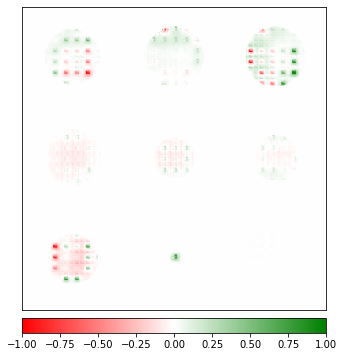

Target: true


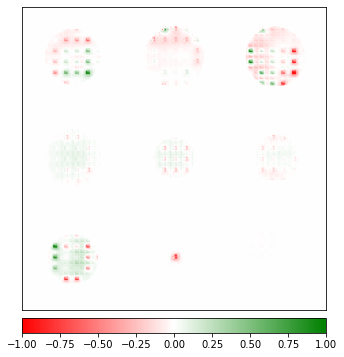

Orig: counterfactual/false


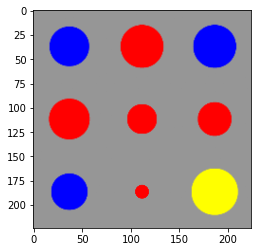

In [ ]:
IG_check(train[0])

Target: counterfactual/false


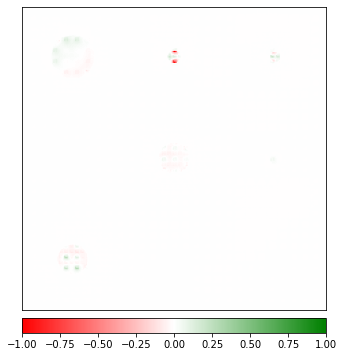

Target: true


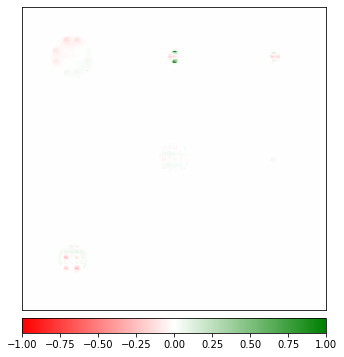

Orig: counterfactual/false


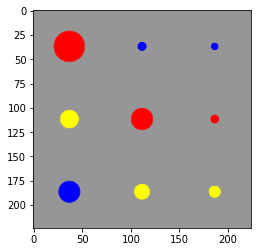

In [ ]:
IG_check(train[888])

Target: counterfactual/false


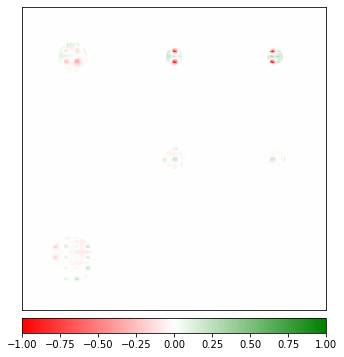

Target: true


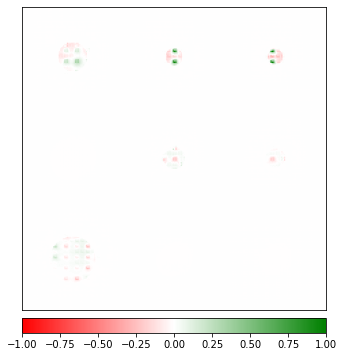

Orig: true


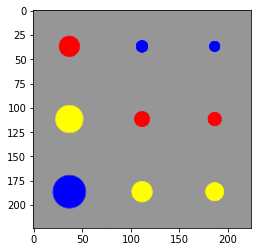

In [ ]:
IG_check(train[1666])

# Lime

In [ ]:
import shap

In [ ]:
from captum.attr import Lime
explainer = Lime(model)

In [ ]:
from skimage import segmentation
## https://scikit-image.org/docs/dev/api/skimage.segmentation.html#skimage.segmentation.slic
mask = segmentation.slic(
    train[39][0].permute(1, 2, 0).mean(axis=2), 
    n_segments=50, 
    compactness=0.1, 
    start_label=0,
    # channel_axis=2 # error :(
  )

maskF = segmentation.slic(
    train[888][0].permute(1, 2, 0).mean(axis=2), 
    n_segments=50, 
    compactness=0.1, 
    start_label=0,
    # channel_axis=2 # error :(
  )


maskT = segmentation.slic(
    train[1666][0].permute(1, 2, 0).mean(axis=2), 
    n_segments=50, 
    compactness=0.1, 
    start_label=0,
    # channel_axis=2 # error :(
  )



In [ ]:
print(mask.max())
mask

95


array([[ 0,  0,  0, ...,  9,  9,  9],
       [ 0,  0,  0, ...,  9,  9,  9],
       [ 0,  0,  0, ...,  9,  9,  9],
       ...,
       [90, 90, 90, ..., 95, 95, 95],
       [90, 90, 90, ..., 95, 95, 95],
       [90, 90, 90, ..., 95, 95, 95]])

In [ ]:
attr = explainer.attribute(
    train[39][0].unsqueeze(0), 
    target=0, 
    n_samples=200, 
    feature_mask=torch.as_tensor(mask),
    show_progress=True
  )


Lime attribution: 100%|██████████| 200/200 [01:20<00:00,  2.48it/s]


In [ ]:
attrF = explainer.attribute(
    train[888][0].unsqueeze(0), 
    target=0, 
    n_samples=200, 
    feature_mask=torch.as_tensor(maskF),
    show_progress=True
  )


Lime attribution: 100%|██████████| 200/200 [01:24<00:00,  2.36it/s]


In [ ]:
attrt = explainer.attribute(
    train[1666][0].unsqueeze(0), 
    target=1, 
    n_samples=200, 
    feature_mask=torch.as_tensor(maskT),
    show_progress=True
  )


Lime attribution: 100%|██████████| 200/200 [01:19<00:00,  2.50it/s]


In [ ]:
def show_image_mask_explanation(image, mask, explanation):
    fig, ax = plt.subplots(1, 3, figsize=[6 * 2, 6])
    ax[0].imshow(image.permute(1, 2, 0))
    ax[0].set_title("image")
    ax[1].imshow(mask, cmap="flag")
    ax[1].set_title("segmentation mask")
    ax[2].imshow(explanation, vmin=-1, vmax=1, cmap="RdBu")
    ax[2].set_title("explanation")
    plt.show()

# Wyniki Lime

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


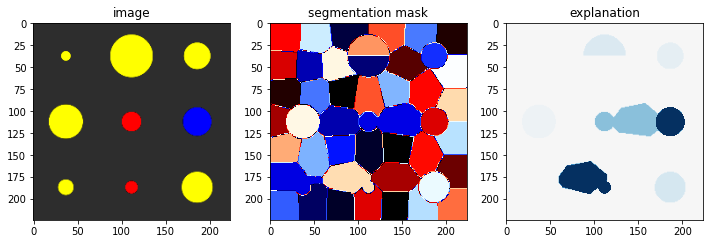

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


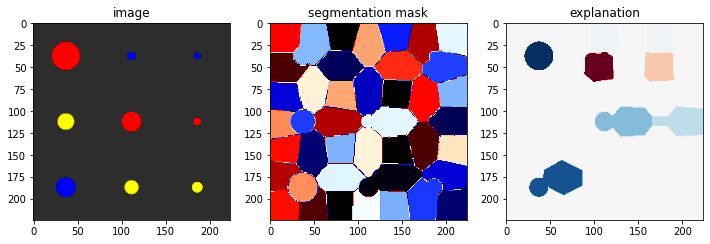

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


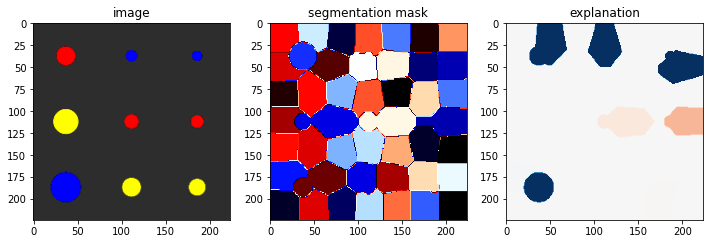

In [ ]:
show_image_mask_explanation(train[39][0], mask, attr[0].mean(axis=0))
show_image_mask_explanation(train[888][0], maskT, attrF[0].mean(axis=0))
show_image_mask_explanation(train[1666][0], maskF, attrt[0].mean(axis=0))

# Articles
## 1. **An Analysis Of Convolutional Neural Networks For Image Classification**
### Neha Sharma, Vibhor Jain, Anju Mishra ,
### Procedia Computer Science, Volume 132, 2018, Pages 377-384, ISSN 1877-0509, https://doi.org/10.1016/j.procs.2018.05.198


The goal of this article was to analyze/compare the performance of AlexNet, GoogLeNet and ResNet50 based on ImageNet, CIFAR 10 and CIFAR 100 by evaluating the consistency of prediction (What are the prediction accuracies of each class for each model?).
* A simple and clear explanation of the layers that can build a network.
* Tables were sometimes confusing to me (short descriptions, unnoticeable).

* Analysis based on more than one data set.
* Only one way of checking performance (consistency of prediction on 10 classes of each data set).

## 2. **Generative causal explanations of black-box classifiers**

### Matthew O'Shaughnessy, Gregory Canal, Marissa Connor, Christopher Rozell, Mark Davenport, https://proceedings.neurips.cc/paper/2020/hash/3a93a609b97ec0ab0ff5539eb79ef33a-Abstract.html

The goal of the article was to develop a method generating causal explanations of a black-box classifier. In order to do that, the authors trained a model to identify two categories of factors: those producing a change in the classifier output (causal factors) and those which don't have any impact on prediction (noncausal factors). Then a generative model was created in order to present how prediction of any observation would change after manipulating any of the factors showing in understandable way (especially when it comes to image classification) what was the real cause of classifier output.

The article does a really good job at explaining complicated ideas by using analogy to simple real life examples. However, it could provide an example of using that method in other field than image classification (not needed for out purposes, but would be nice anyway). Overall - good read and easy to understand, eye-catching results.

## 3. Multifaceted Feature Visualization: Uncovering the Different Types of Features Learned By Each Neuron in Deep Neural Networks

### Anh Nguyen, Jason Yosinski, Jeff Clune, 

https://arxiv.org/abs/1602.03616

The article presents an innovative method of generating visual explanations and highlighting factors, which are crucial in the process of image classifying. Described method proves that DNNs learn global structure, context and details, not only selected, discriminate features of each class. The goal is to synthetically generate images that maximize the activation of each of the neurons. Resulting images are surprisingly realistic (although sometimes more surrealistic), so they can serve as a very interesting source of knowledge whether our model is explainable or not.

I was really surprised by the effects presented in this article. They're certainly jaw-dropping and very informative. One has to say that this innovative, understandable explanation-generating tool looks incredibly promising if it could be developed further. Overally, there was only one thing I lacked. All of the generated explanations were based on AlexNet and there was no comparision between the other models. I think it could be really intriguing to see how they differ in their key focus areas.